In [201]:
import os
import os.path as op
import numpy as np
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from moss import glm
import glob
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.io as sio
import scipy.stats
from scipy.optimize import minimize
import statsmodels.formula.api as smf
import multiprocessing
import random
from scipy.stats import norm
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [772]:
sub_list = ['23','24','25','26','27','28','30','31','32','35','36','37','39','40']
# sub_list = ['23']
nruns = 6
home_dir = '/Users/ianballard/Dropbox/rule_learning/'
flatui = ["#9b59b6", "#3498db", "#2ecc71","#95a5a6", "#e74c3c", "#34495e"]


In [773]:
psych_regressor = 'kl'
mask = home_dir + 'masks/caudate_dlpfc_conn+tlrc.HEAD'
roi_name = 'caudate_exec'
for sub in sub_list: 
    os.chdir(op.join(home_dir, 'mri_data', 'rule_learning_' + sub ,'brik'))
    cmd = ['3dmaskave','-mask', mask,
           '-quiet','all_runs.rule_learning_' + sub + '+tlrc.BRIK', '>',roi_name + '_avg_ian.1D']
    os.system(' '.join(cmd))
    
    roi_ts = np.loadtxt(roi_name + '_avg_ian.1D')
    tr_starts = np.loadtxt('TR_starts.txt').astype(int)
    tr_starts = np.concatenate((tr_starts,[len(roi_ts)+1]))

    for run in range(nruns):
        #extract roi data
        run_data = roi_ts[tr_starts[run]:tr_starts[run+1]]
        run_data[0:4]=100 #deal with initial transients
        out_f1 = roi_name + '_run_' + str(run + 1) + '.1D'
        np.savetxt(out_f1,run_data, newline=" ")

        #detrend
        out_f2 = roi_name + '_detrend_run_' + str(run + 1) + '.1D' 
        cmd = ['3dDetrend','-polort','3','-prefix',out_f2,out_f1]
        os.system(' '.join(cmd))
       
        

In [627]:
def regress_other_conds(data,sub_dir,run):
    cue_onsets = load_onsets(sub_dir,'cue')
    resp_onsets = load_onsets(sub_dir,'response')
    ntrials = len(cue_onsets[run])

    #build design
    design = pd.DataFrame({'condition':['cue']*ntrials + ['response']*ntrials,
                      'onset': list(cue_onsets[run]) + list(resp_onsets[run]),
                      'duration': [0]*ntrials + [0]*ntrials,
                     })

    #convolve 
    tr = 1
    hrf = glm.GammaDifferenceHRF(tr = tr, temporal_deriv=True)
    ntp = len(data)
    model = glm.DesignMatrix(design = design, tr = tr, ntp = ntp, 
                             hrf_model = hrf, hpf_cutoff = None,
                            )
    model = model.design_matrix.reset_index()


    #detrend
    cols = model.columns.values
    cols = [x for x in cols if x != 'frametimes']
    for c in cols:
        polyfit = np.polyfit(model['frametimes'],
                           model[c],
                           3)
        predicted = np.polyval(polyfit, model['frametimes'])
        model[c] = model[c] - predicted
    
    #regress
    model['data'] = data
    model_str = 'data ~ 1 + cue + response + cue_deriv + response_deriv'
    ols = smf.ols(model_str,data = model).fit()
    return ols.resid.values, model

In [774]:
def load_onsets(sub_dir, condition):
    o = np.loadtxt(op.join(sub_dir,condition + '_onsets'))
    onsets = {}
    for run,row in enumerate(o):
        onsets[run] = row
    return onsets

In [775]:
df = {'signal':[],'trial':[],'sub':[],'run':[], 'lag':[]}

for sub in sub_list:
    sub_dir = op.join(home_dir, 'mri_data', 'rule_learning_' + sub ,'brik')
    cond_onsets = load_onsets(sub_dir,'feedback')

    for run in range(nruns):

        #load data
        out_f2 = op.join(sub_dir,roi_name + '_detrend_run_' + str(run + 1) + '.1D')
        data = np.loadtxt(out_f2)

        #upsample to one second
        cs = scipy.interpolate.CubicSpline(range(len(data)),data)
        data = cs(np.arange(0,len(data),.5))
        
        #regress out cue and response periods
        cleaned_data, model = regress_other_conds(data,sub_dir,run)
        
        #loop through lags
        for lag in range(12):
            onsets = [int(x) + lag for x in cond_onsets[run]]
            while onsets[-1] >= len(cleaned_data):
                cleaned_data = np.hstack([cleaned_data,np.NaN])
            signal = cleaned_data[onsets]

            df['signal'].extend(signal)
            df['trial'].extend(range(len(signal)))
            df['sub'].extend([sub]*len(signal))
            df['run'].extend([run]*len(signal))
            df['lag'].extend([lag]*len(signal))

df = pd.DataFrame(df).dropna()

In [776]:
df = df.dropna()

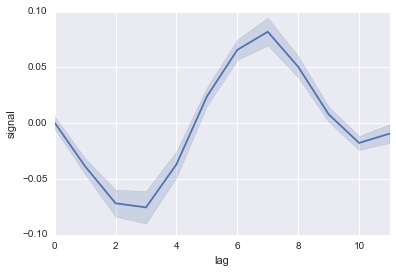

In [777]:
fig_df = df.groupby(['sub','lag']).mean().reset_index()
sns.tsplot(time = 'lag',value = 'signal',unit = 'sub',data = fig_df)

In [778]:
run_to_cond = {1:'A and B',2:'(A and B) or C',3:'A or B',4:'A',5:'A xor B',6:'(A or B) and C'}
df['condition'] = [run_to_cond[x+1] for x in df['run']]

In [779]:
#load behavioral data
behav = pd.read_csv(home_dir + '/behavioral_data.csv')
model = behav[behav['sub'] == 'model'].copy() #bayesian model
behav = behav[behav['sub'] != 'model']
behav['hit'] = np.NaN
behav = behav.set_index(['sub','condition','trial']).sort_index()

#calculate surprise
model['surprise'] = [1 - x for x in model['hits']]
model = model.set_index(['condition','trial']).sort_index()

#load RL PE
rl = pd.read_csv(home_dir + 'rl_predictions.csv')
rl = rl.set_index(['condition','trial']).sort_index()


In [780]:
df = df.set_index(['sub','condition','trial']).sort_index()

In [781]:
#enter information about condition, RL PE, and surprise
for row in set(behav.index):
    hit = behav.loc[row,'hits']
    pe = rl.loc[row[1:],'pe']
    surprise = model.loc[row[1:],'surprise']

    df.loc[row,'hit'] = hit
    df.loc[row,'pe'] = pe
    df.loc[row,'surprise'] = surprise

df = df.reset_index()

In [782]:
hit_map = {0:'Incorrect',1:'Correct'}

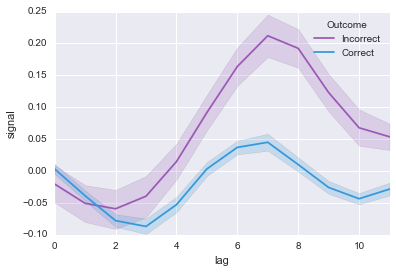

In [783]:
fig_df = df.groupby(['sub','lag','hit']).mean().reset_index()
fig_df['Outcome'] = [hit_map[x] for x in fig_df['hit']]
sns.tsplot(time = 'lag',value = 'signal',unit = 'sub',condition = 'Outcome',
           data = fig_df,color = sns.color_palette(flatui))

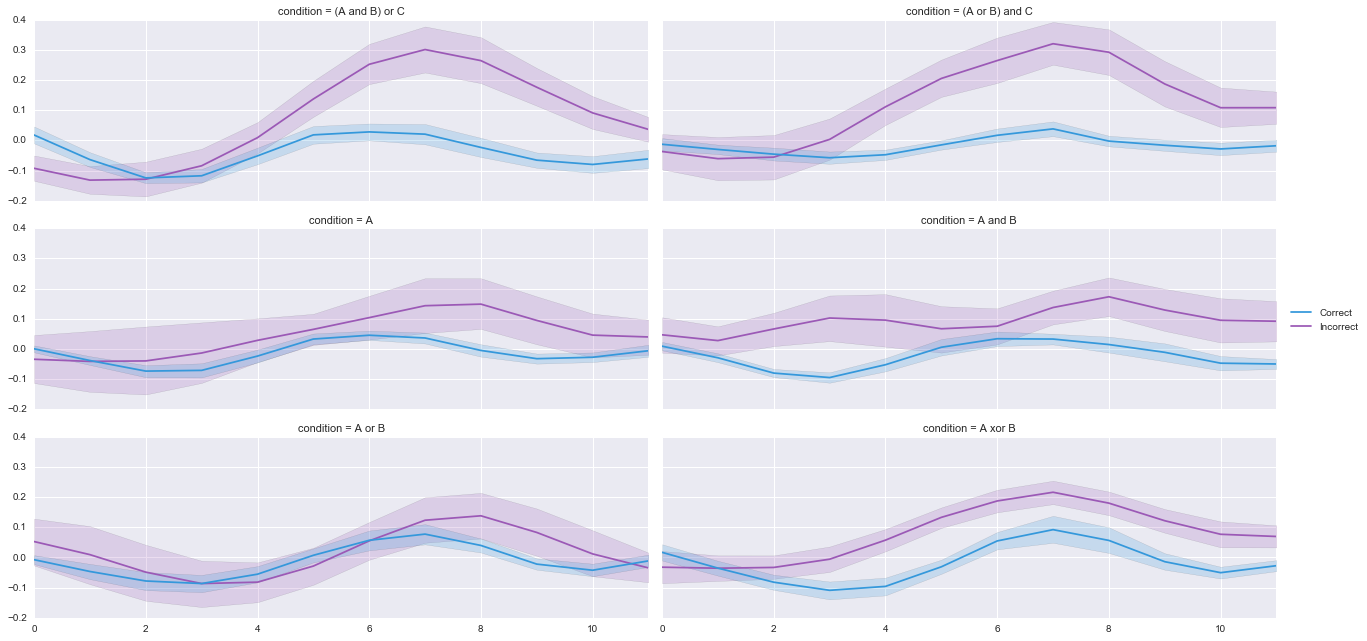

In [784]:
fig_df = df.groupby(['sub','lag','hit','condition']).mean().reset_index()
fig_df['Outcome'] = [hit_map[x] for x in fig_df['hit']]
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(fig_df, col='condition',col_wrap = 2, aspect = 3)
g.map_dataframe(sns.tsplot, time="lag", unit="sub",
                value="signal", condition = 'Outcome',color = sns.color_palette(flatui)).add_legend()
# plt.savefig(home_dir + '/figures/model_fits_noise.png',dpi=600)

In [785]:
def split_chunks(x,param):
    if x < np.percentile(df[param], 33):
        return 'low'
    elif x < np.percentile(df[param], 66):
        return 'medium'
    else:
        return 'high'

In [786]:
df['pe_split'] = [split_chunks(x,'pe') for x in df['pe']]

In [787]:
df['surprise_split'] = [split_chunks(x,'surprise') for x in df['surprise']]

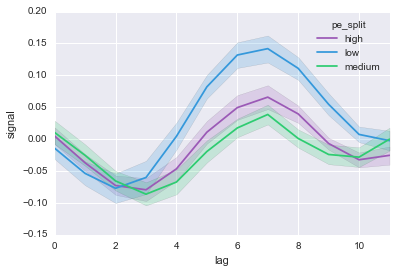

In [788]:
fig_df = df.groupby(['sub','lag','pe_split']).mean().reset_index()
sns.tsplot(time = 'lag',value = 'signal',unit = 'sub',condition = 'pe_split',
           data = fig_df,color = sns.color_palette(flatui))

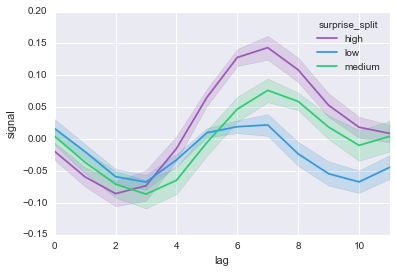

In [789]:
fig_df = df.groupby(['sub','lag','surprise_split']).mean().reset_index()
sns.tsplot(time = 'lag',value = 'signal',unit = 'sub',condition = 'surprise_split',
           data = fig_df,color = sns.color_palette(flatui))

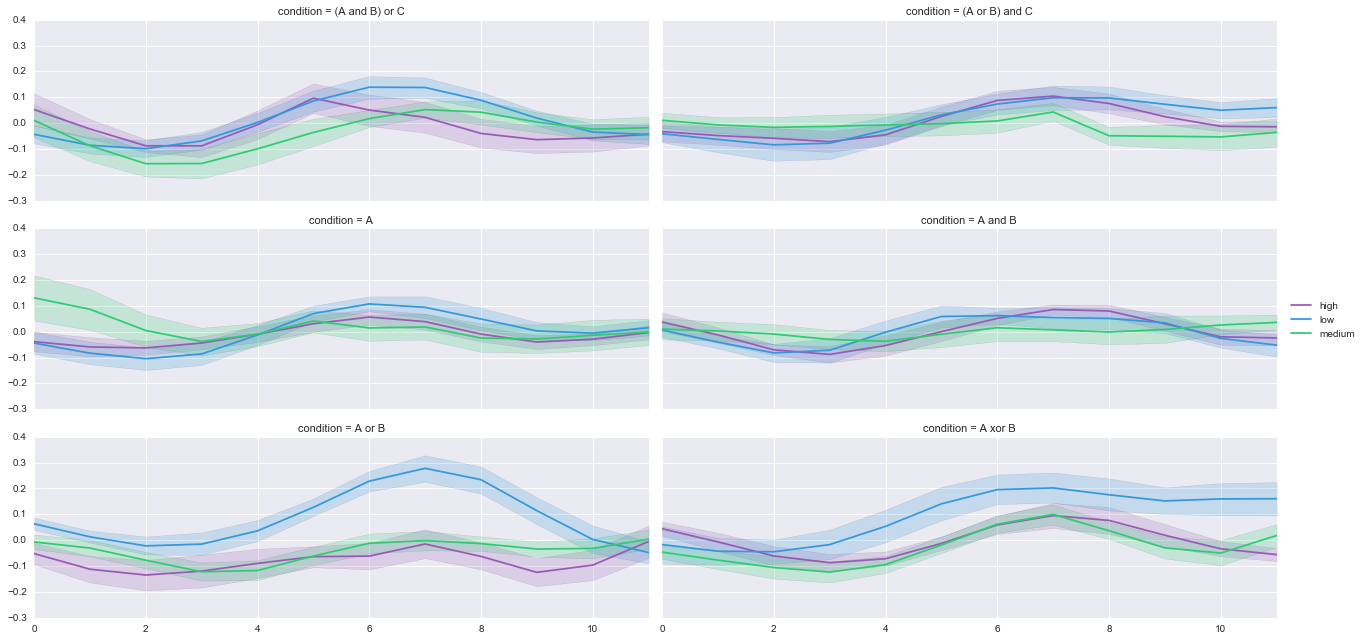

In [790]:
fig_df = df.groupby(['sub','lag','pe_split','condition']).mean().reset_index()
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(fig_df, col='condition',col_wrap = 2, aspect = 3)
g.map_dataframe(sns.tsplot, time="lag", unit="sub",
                value="signal", condition = 'pe_split',color = sns.color_palette(flatui)).add_legend()
# plt.savefig(home_dir + '/figures/model_fits_noise.png',dpi=600)

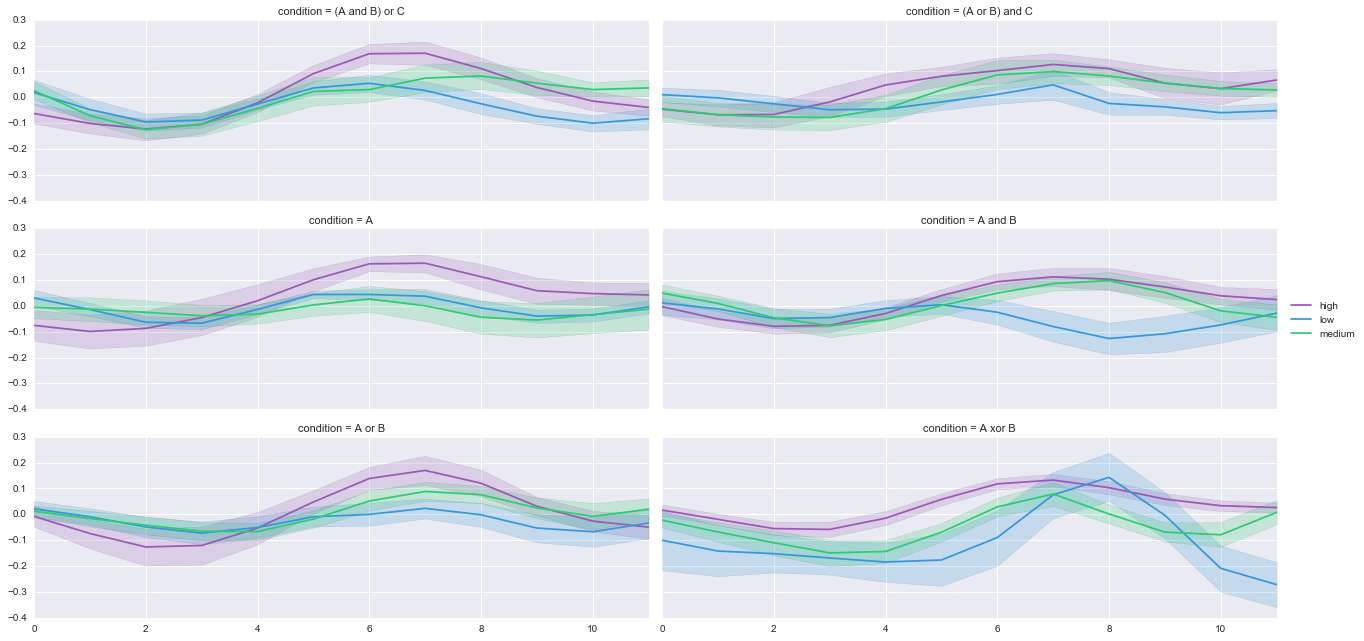

In [791]:
fig_df = df.groupby(['sub','lag','surprise_split','condition']).mean().reset_index()
plt.figure(figsize=(8, 20))
g = sns.FacetGrid(fig_df, col='condition',col_wrap = 2, aspect = 3)
g.map_dataframe(sns.tsplot, time="lag", unit="sub",
                value="signal", condition = 'surprise_split',color = sns.color_palette(flatui)).add_legend()
# plt.savefig(home_dir + '/figures/model_fits_noise.png',dpi=600)

In [752]:
def remove_intercept_variance(x, group_mean):
    return x - x.mean() + group_mean

In [792]:
evoked = df[df['lag'] >=5]
evoked = evoked[evoked['lag'] <=8]
evoked = evoked.groupby(['sub','condition','trial']).mean().reset_index()

In [793]:
evoked['signal_demeaned'] = evoked.groupby('sub').signal.transform(remove_intercept_variance,
                                                                  evoked.signal.mean())

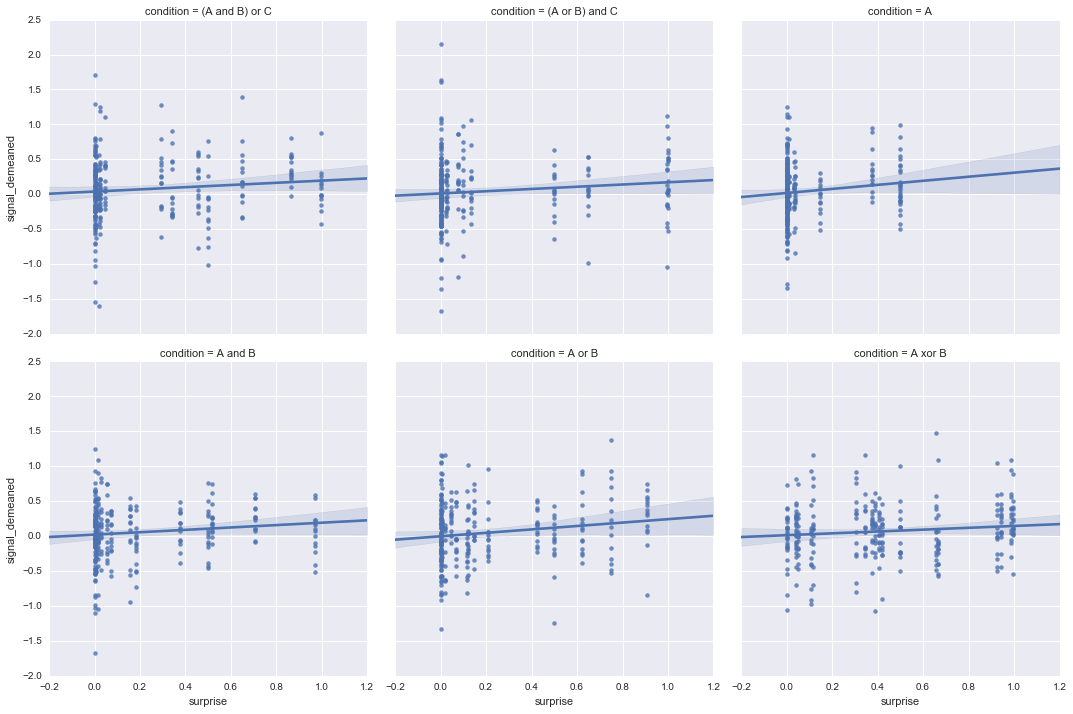

In [794]:
g = sns.lmplot(x="surprise", y="signal_demeaned", col="condition",units = 'sub',
               robust = True,
               data=evoked, col_wrap=3, size=5)

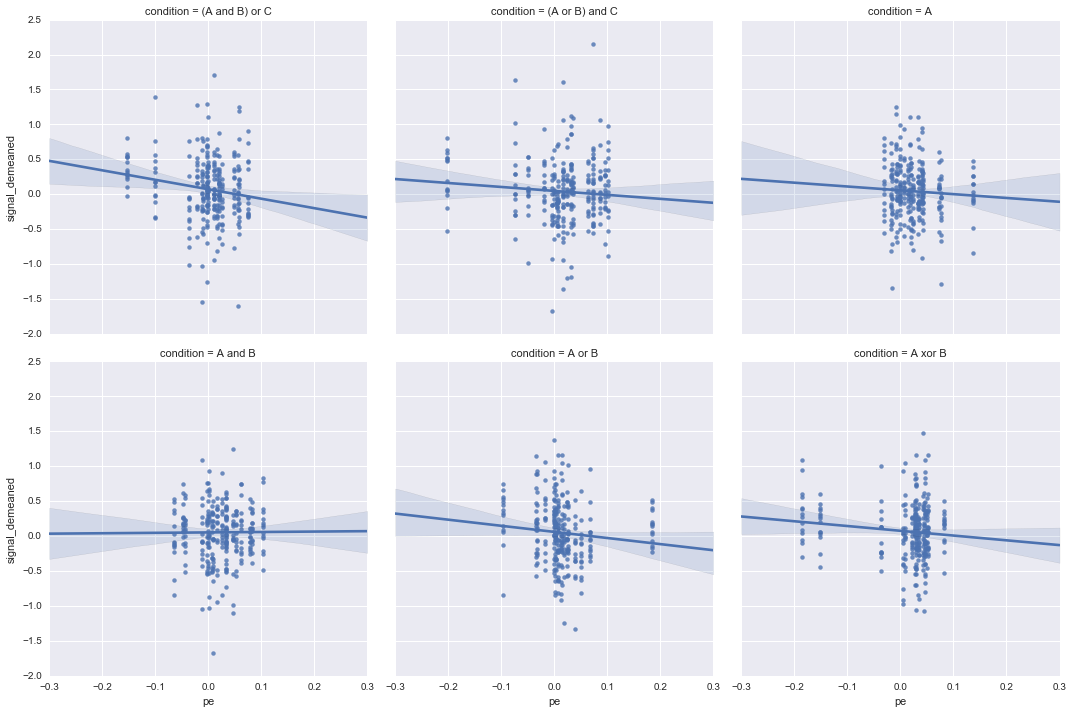

In [795]:
g = sns.lmplot(x="pe", y="signal_demeaned", col="condition",units = 'sub',
               data=evoked, col_wrap=3, size=5, robust = True)

In [803]:
for cond in set(evoked['condition']):
    print cond
    cond_df = evoked[evoked['condition'] == cond]

    model_str = 'signal ~ surprise'
    mixedfx = smf.mixedlm(model_str, cond_df, groups = cond_df['sub'])    
    mixedfx = mixedfx.fit()
    print mixedfx.summary()

A
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1504   
Min. group size:  20      Likelihood:         -134.9671
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.019    0.026 0.753 0.451 -0.031  0.070
surprise       0.329    0.142 2.322 0.020  0.051  0.606
Intercept RE   0.000                                   


//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



(A and B) or C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1945   
Min. group size:  20      Likelihood:         -171.3138
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.040    0.032 1.263 0.207 -0.022  0.103
surprise       0.163    0.085 1.924 0.054 -0.003  0.329
Intercept RE   0.000                                   

A or B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1874   
Min. group size:  20      Likelihood:     

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A and B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1506   
Min. group size:  20      Likelihood:         -135.6780
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.010    0.028 0.344 0.731 -0.045  0.064
surprise       0.174    0.084 2.066 0.039  0.009  0.340
Intercept RE   0.000                                   

(A or B) and C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.2088   
Min. group size:  20      Likelihood:    

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A xor B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1552   
Min. group size:  20      Likelihood:         -140.0955
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.007    0.037 0.180 0.857 -0.066  0.080
surprise       0.160    0.070 2.300 0.021  0.024  0.296
Intercept RE   0.000                                   



In [797]:
for cond in set(evoked['condition']):
    print cond
    cond_df = evoked[evoked['condition'] == cond]

    model_str = 'signal ~ 1 + pe'
    mixedfx = smf.mixedlm(model_str, cond_df, groups = cond_df['sub'])    
    mixedfx = mixedfx.fit()
    print mixedfx.summary()

A
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1524   
Min. group size:  20      Likelihood:         -135.3219
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.065    0.028  2.359 0.018  0.011  0.119
pe           -0.804    0.613 -1.311 0.190 -2.005  0.398
Intercept RE  0.000                                    


//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



(A and B) or C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1929   
Min. group size:  20      Likelihood:         -168.3888
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.075    0.026  2.847 0.004  0.023  0.126
pe           -1.255    0.513 -2.445 0.014 -2.262 -0.249
Intercept RE  0.000                                    

A or B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1890   
Min. group size:  20      Likelihood:     

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A and B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1528   
Min. group size:  20      Likelihood:         -135.8323
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.036    0.026 1.386 0.166 -0.015  0.087
pe             0.247    0.547 0.452 0.651 -0.825  1.320
Intercept RE   0.000                                   

(A or B) and C
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.2095   
Min. group size:  20      Likelihood:    

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



A xor B
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: signal   
No. Observations: 280     Method:             REML     
No. Groups:       14      Scale:              0.1559   
Min. group size:  20      Likelihood:         -139.0306
Max. group size:  20      Converged:          Yes      
Mean group size:  20.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.082    0.024  3.408 0.001  0.035  0.129
pe           -0.741    0.367 -2.020 0.043 -1.460 -0.022
Intercept RE  0.000                                    



In [802]:
evoked.groupby(['sub','condition']).mean()['signal']

sub  condition     
23   (A and B) or C    0.033004
     (A or B) and C    0.058045
     A                 0.095787
     A and B           0.075714
     A or B            0.055838
     A xor B           0.041530
24   (A and B) or C    0.049677
     (A or B) and C    0.061257
     A                 0.034104
     A and B           0.027317
     A or B            0.000397
     A xor B           0.030256
25   (A and B) or C    0.054730
     (A or B) and C    0.092193
     A                 0.064473
     A and B           0.090850
     A or B            0.007156
     A xor B           0.158313
26   (A and B) or C    0.058649
     (A or B) and C    0.113285
     A                -0.008702
     A and B           0.062319
     A or B            0.108047
     A xor B           0.037077
27   (A and B) or C    0.124459
     (A or B) and C    0.045310
     A                 0.036753
     A and B           0.046393
     A or B            0.040414
     A xor B           0.093254
                    